## Data Preparation

In [103]:
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import unidecode
import nltk
import re

# Initialisation des outils de prétraitement
stop_words = set(stopwords.words('french'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Global and constant
DEFAULT_CV = 10

# Fonction de prétraitement des données
def preprocess(text):
    text = unidecode.unidecode(text) # Suppression des accents
    text = re.sub(r'[^\w\s]', '', text) # Suppression des caractères spéciaux
    text = text.lower() # Conversion en minuscules

    tokens = nltk.word_tokenize(text) # Tokenisation
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens] # Lemmatisation
    stemmed_tokens = [stemmer.stem(token) for token in lemmatized_tokens] # Stemming
    cleaned_tokens = [token for token in stemmed_tokens if token not in stop_words] # Suppression des mots vides
    
    text = ' '.join(cleaned_tokens) # Réassemblage du texte pré-traité
    return text

In [104]:
import numpy as np
import json

def prepare_data(file_path="donnees_clusterisees.json", ignore_labels=[]):
    # Chargement des données à partir du fichier JSON
    with open(file_path, 'r') as f:
        data = json.load(f)
        
    # On evite d'importer les données mal etiquete
    data = [d for d in data if d['label'] not in ignore_labels]
    labels = [d['label'] for d in data if d['label'] not in ignore_labels]

    # Extraction de la colonne "name" et "description"
    names = [d['name'] for d in data]
    cleaned_names = [preprocess(name) for name in names]

    return cleaned_names, labels

## Learning

### Train different models
---

We define a function to compute the CI at 95% for each of the methods, for each best hyperparameter.

In [105]:
# Calculate 95% confidence interval
def compute_ci_95(cv_scores):
    std_error = np.std(cv_scores) / np.sqrt(DEFAULT_CV)
    best_score = max(cv_scores)

    # Calculate the 95% confidence interval of the cross-validation scores
    lower_bound = best_score - 1.96 * std_error
    upper_bound = best_score + 1.96 * std_error
    
    return lower_bound, upper_bound

#### K-nearest neighbors

In [106]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

def get_best_hyperparam_KNNClassifier(neighbors_range, X_train, Y_train):
    # Store the scores
    cv_scores = []
    
    # Loop over the hyperparameter values
    for k in neighbors_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, Y_train, cv=DEFAULT_CV)
        cv_scores.append(scores.mean())

    lower_bound, upper_bound = compute_ci_95(cv_scores)
    best_score = max(cv_scores)
    
    # Find the best hyperparameter with the highest score
    best_k = neighbors_range[cv_scores.index(max(cv_scores))]
    return best_k, best_score, lower_bound, upper_bound

#### Decision trees (max_depth)

In [107]:
from sklearn.tree import DecisionTreeClassifier

def get_best_hyperparam_TreeClassifier(depth_range, X_train, Y_train):
    # Store the scores
    cv_scores = []

    # Loop over the hyperparameter values
    for depth in depth_range:
        dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
        scores = cross_val_score(dt, X_train, Y_train, cv=DEFAULT_CV)
        cv_scores.append(np.mean(scores))

    lower_bound, upper_bound = compute_ci_95(cv_scores)
    best_score = max(cv_scores)
    
    # Find the best hyperparameter with the highest score
    best_depth = depth_range[np.argmax(cv_scores)]
    return best_depth, best_score, lower_bound, upper_bound 

#### SVC Gaussian

In [108]:
from sklearn.svm import SVC

def get_best_hyperparam_SVCGaussian(gammas, X_train, Y_train):
    # Store the scores
    cv_scores = []

    # Find the best hyperparameter with the highest score
    for gamma in gammas:
        svm = SVC(kernel='rbf', gamma=gamma)
        scores = cross_val_score(svm, X_train, Y_train, cv=DEFAULT_CV)
        cv_scores.append(scores.mean())
    
    lower_bound, upper_bound = compute_ci_95(cv_scores)
    best_score = max(cv_scores)
    
    # Find the best hyperparameter with the highest score
    best_gamma = gammas[cv_scores.index(max(cv_scores))]
    return best_gamma, best_score, lower_bound, upper_bound

#### MultinomialNB

In [109]:
from sklearn.naive_bayes import MultinomialNB

def get_best_hyperparam_MultinomialNB(alphas, X_train, Y_train):
    # Create an empty list to store the cross-validation scores for each hyperparameter value
    cv_scores = []
    
    # Loop over the hyperparameter values and compute the cross-validation score for each
    for alpha in alphas:
        mnb = MultinomialNB(alpha=alpha)
        scores = cross_val_score(mnb, X_train, Y_train, cv=DEFAULT_CV)
        cv_scores.append(scores.mean())

    lower_bound, upper_bound = compute_ci_95(cv_scores)
    best_score = max(cv_scores)
    
    # Find the best hyperparameter value with the highest cross-validation score
    best_alpha = alphas[cv_scores.index(max(cv_scores))]
    return best_alpha, best_score, lower_bound, upper_bound

#### SVC Polynomial

In [110]:
from sklearn.svm import SVC

def get_best_hyperparam_SVCPolynomial(degrees, X_train, Y_train):
    # Store the scores
    cv_scores = []

    # Find the best hyperparameter with the highest score
    for degree in degrees:
        svm = SVC(kernel='poly', degree=degree)
        scores = cross_val_score(svm, X_train, Y_train, cv=DEFAULT_CV)
        cv_scores.append(scores.mean())

    lower_bound, upper_bound = compute_ci_95(cv_scores)
    best_score = max(cv_scores)
    
    # Find the best hyperparameter with the highest score
    best_degree = degrees[cv_scores.index(max(cv_scores))]  
    return best_degree, best_score, lower_bound, upper_bound

---
### Results analysis
We will display on a curve the scores of each of the algorithms with the best possible hyperparameter value on the test sample.

---
Let's first define a generic function to plot the scores of each algorithms with the best hyperparameter

In [111]:
import matplotlib.pyplot as plt

def show_results_plot(results, title):
    # Get the data
    classifiers = [r['Classifier'] for r in results]
    best_scores = [r['Best Score'] for r in results]
    accuracies = [r['Accuracy'] for r in results]
    f1_scores = [r['F1 Score'] for r in results]
    precisions = [r['Precision'] for r in results]

    # Set the width of the bars
    bar_width = 0.2

    # Set the positions of the bars on the x-axis
    r1 = np.arange(len(classifiers))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]

    # Set the colors and edgecolors of the bars
    best_score_color = "#1f77b4"
    accuracy_color = '#ff7f0e'
    f1_score_color = '#2ca02c'
    precision_color = '#d62728'

    edgecolors = 'black'

    # Plot the bar charts
    plt.bar(r1, best_scores, color=best_score_color, edgecolor=edgecolors, width=bar_width, label='Best Score')
    plt.bar(r2, accuracies, color=accuracy_color, edgecolor=edgecolors, width=bar_width, label='Accuracy')
    plt.bar(r3, f1_scores, color=f1_score_color, edgecolor=edgecolors, width=bar_width, label='F1 Score')
    plt.bar(r4, precisions, color=precision_color, edgecolor=edgecolors, width=bar_width, label='Precision')

    # Add xticks on the middle of the group bars
    plt.xlabel('Classifier', fontweight='bold')
    plt.xticks([r + bar_width*1.5 for r in range(len(classifiers))], classifiers, rotation=45, ha='right')
    plt.ylabel('Score', fontweight='bold')

    # Add a title
    plt.title(title, fontweight='bold')
    plt.legend()

    # Set the figure size
    plt.gcf().set_size_inches(15, 8)

    # Set the y-axis range
    plt.ylim(0, 1)
    plt.yticks(np.arange(0, 1.1, 0.1))

    # Show the plot
    plt.show()

We also define a function to evaluate the classification models

In [112]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_classification_model(model, X_test, Y_test):
    # Predict on test data
    Y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics on test data
    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='weighted')
    recall = recall_score(Y_test, Y_pred, average='weighted')
    f1 = f1_score(Y_test, Y_pred, average='weighted')

    # Return evaluation metrics and confidence interval
    return accuracy, precision, recall, f1, Y_pred

In [113]:
# Lets define some constant to make the code more readable
CLASSIFIER = "Classifier"
HYPERPARAMETER = "Hyperparameter"
BEST_HYPERPARAMETER = "Best Hyperparameter"
BEST_SCORE = "Best Score"
LOWER_BOUND = "Lower Bound"
UPPER_BOUND = "Upper Bound"
F1_SCORE = "F1 Score"
RECALL = "Recall"
ACCURACY = "Accuracy"
PRECISION = "Precision" 
PREDICTION = "Prediction"

We define the function to predict the class of the monuments with different classifiers

In [114]:
def predict_with_KNN(X_train, X_test, Y_train, Y_test):
    neighbors_range = range(1, 20)
    best_k, best_score, lower_bound, upper_bound = get_best_hyperparam_KNNClassifier(neighbors_range, X_train, Y_train)

    # Train KNN classifier
    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn.fit(X_train, Y_train)

    # evaluate the model
    accuracy, precision, recall, f1, Y_pred = evaluate_classification_model(knn, X_test, Y_test)
    return {
        CLASSIFIER: 'K-nearest neighbors',
        HYPERPARAMETER: 'Number of neighbors',
        BEST_HYPERPARAMETER: best_k,
        BEST_SCORE: best_score,
        LOWER_BOUND: lower_bound,
        UPPER_BOUND: upper_bound,
        F1_SCORE: f1,
        ACCURACY: accuracy,
        PRECISION: precision,
        RECALL: recall,
        PREDICTION: Y_pred
    }

def predict_with_DECISIONTREE(X_train, X_test, Y_train, Y_test):
    depth_range = range(1, 21)
    best_depth, best_score, lower_bound, upper_bound = get_best_hyperparam_TreeClassifier(depth_range, X_train, Y_train)

    # Train classifier
    dect = DecisionTreeClassifier(max_depth=best_depth)
    dect.fit(X_train, Y_train)

    # evaluate the model
    accuracy, precision, recall, f1, Y_pred = evaluate_classification_model(dect, X_test, Y_test)
    return {
        CLASSIFIER: 'Decision tree',
        HYPERPARAMETER: 'Maximum tree depth',
        BEST_HYPERPARAMETER: best_depth,
        BEST_SCORE: best_score,
        LOWER_BOUND: lower_bound,
        UPPER_BOUND: upper_bound,    
        F1_SCORE: f1,
        ACCURACY: accuracy,
        PRECISION: precision,
        RECALL: recall,
        PREDICTION: Y_pred
    }

def predict_with_MultinomialNB(X_train, X_test, Y_train, Y_test):
    # Define the range of values for the hyperparameter to tune
    alphas = range(1, 25)
    best_alpha, best_score, lower_bound, upper_bound = get_best_hyperparam_MultinomialNB(alphas, X_train, Y_train)

    # Train classifier
    perc = MultinomialNB(alpha=best_alpha)
    perc.fit(X_train, Y_train)

    # evaluate the model
    accuracy, precision, recall, f1, Y_pred = evaluate_classification_model(perc, X_test, Y_test)
    return {
        CLASSIFIER: 'Multinomial NB',
        HYPERPARAMETER: 'Alpha',
        BEST_HYPERPARAMETER: best_alpha,
        BEST_SCORE: best_score,
        LOWER_BOUND: lower_bound,
        UPPER_BOUND: upper_bound,
        F1_SCORE: f1,
        ACCURACY: accuracy,
        PRECISION: precision,
        RECALL: recall,
        PREDICTION: Y_pred
    }

def predict_with_SVCGAUSSIAN(X_train, X_test, Y_train, Y_test):
    # Define the range of values for the hyperparameter to tune
    gammas = np.arange(0.01, 1, 0.1)
    best_gamma, best_score, lower_bound, upper_bound = get_best_hyperparam_SVCGaussian(gammas, X_train, Y_train)

    # Train classifier
    svc_gaussian = SVC(kernel='rbf', gamma=best_gamma)
    svc_gaussian.fit(X_train, Y_train)

    # evaluate the model
    accuracy, precision, recall, f1, Y_pred = evaluate_classification_model(svc_gaussian, X_test, Y_test)
    return {
        CLASSIFIER: 'Gaussian SVM',
        HYPERPARAMETER: 'Gamma',
        BEST_HYPERPARAMETER: best_gamma,
        BEST_SCORE: best_score,
        LOWER_BOUND: lower_bound,
        UPPER_BOUND: upper_bound,
        F1_SCORE: f1,
        ACCURACY: accuracy,
        PRECISION: precision,
        RECALL: recall,
        PREDICTION: Y_pred
    }

def predict_with_SVCPOLYNOMIAL(X_train, X_test, Y_train, Y_test):
    # Define the range of values for the hyperparameter to tune
    degrees = range(1, 6)
    best_degree, best_score, lower_bound, upper_bound = get_best_hyperparam_SVCPolynomial(degrees, X_train, Y_train)

    # Train classifier
    svc_gaussian = SVC(kernel='poly', degree=best_degree)
    svc_gaussian.fit(X_train, Y_train)

    # evaluate the model
    accuracy, precision, recall, f1, Y_pred = evaluate_classification_model(svc_gaussian, X_test, Y_test)
    return {
        CLASSIFIER: 'Polynomial SVM',
        HYPERPARAMETER: 'Degree',
        BEST_HYPERPARAMETER: best_degree,
        BEST_SCORE: best_score,
        LOWER_BOUND: lower_bound,
        UPPER_BOUND: upper_bound,
        F1_SCORE: f1,
        ACCURACY: accuracy,
        PRECISION: precision,
        RECALL: recall,
        PREDICTION: Y_pred
    }

---
### Prediction results
---
Lets write a general function to display the results in a dataframe

In [115]:
import pandas as pd

def result_into_df(results):  
    df = pd.DataFrame(results)
    df_sorted = df.sort_values(by=BEST_SCORE, ascending=False)

    return df_sorted

We also define a general function to plot the classifed data 

In [116]:
import plotly.graph_objects as go
import plotly.express as px

def show_monuments_by_label(Y_pred, X_test):
    # Create a list of monument names
    monuments = vectorizer.inverse_transform(X_test)
    names = [', '.join(m) for m in monuments]

    # Create a data frame with the monument names, their predicted labels, and their index in the test set
    df = pd.DataFrame({'Monument': names, 'Label': Y_pred, 'Index': list(range(X_test.shape[0]))})

    # Create a dictionary to map labels to colors
    label_to_color = {label: color for label, color in zip(df['Label'].unique(), px.colors.qualitative.Dark24)}

    # Create a trace for each label
    traces = []
    for label, color in label_to_color.items():
        mask = df['Label'] == label
        traces.append(go.Scatter(x=df.loc[mask, 'Index'], y=[label] * mask.sum(),
                                 mode='markers',
                                 text=df.loc[mask, 'Monument'],
                                 hovertemplate='%{text}',
                                 marker=dict(size=10, color=color),
                                 name='Label {}'.format(label)))

    # Set the plot title and axis labels
    layout = go.Layout(title='Monument Labels',
                       xaxis_title='Monument Index',
                       yaxis_title='Predicted Label')

    # Create the figure and show the plot
    fig = go.Figure(data=traces, layout=layout)
    fig.show()

We define another function to split the data on a training and tests set.

In [117]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

def split_data_training_test(X, labels, test_size=0.3):
    X_train, X_test, Y_train, Y_test = train_test_split(X, labels, test_size=test_size, random_state=42)
    
    # Fit and transform the CountVectorizer on your training data
    X_train = vectorizer.fit_transform(X_train)

    # Transform the test data using CountVectorizer object
    X_test = vectorizer.transform(X_test)
    return X_train, X_test, Y_train, Y_test

In [118]:
def predict_monuments_class():
    data, labels = prepare_data(ignore_labels=[3])
    X_train, X_test, Y_train, Y_test = split_data_training_test(data, labels)
    
    results = []
    results.append(predict_with_KNN(X_train, X_test, Y_train, Y_test)) 
    results.append(predict_with_DECISIONTREE(X_train, X_test, Y_train, Y_test))
    results.append(predict_with_MultinomialNB(X_train, X_test, Y_train, Y_test))
    results.append(predict_with_SVCGAUSSIAN(X_train, X_test, Y_train, Y_test))
    results.append(predict_with_SVCPOLYNOMIAL(X_train, X_test, Y_train, Y_test))
    
    return results, X_test

In [119]:
results, X_test = predict_monuments_class()
df = result_into_df(results)
df

,Classifier,Hyperparameter,Best Hyperparameter,Best Score,Lower Bound,Upper Bound,F1 Score,Accuracy,Precision,Recall,Prediction
2,Multinomial NB,Alpha,1.00,1.000000,0.999858,1.000142,1.000000,1.00000,1.000000,1.00000,"[2, 1, 2, 2, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 1, ..."
4,Polynomial SVM,Degree,1.00,1.000000,0.999827,1.000173,1.000000,1.00000,1.000000,1.00000,"[2, 1, 2, 2, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 1, ..."
3,Gaussian SVM,Gamma,0.01,0.999432,0.996543,1.002321,1.000000,1.00000,1.000000,1.00000,"[2, 1, 2, 2, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 1, ..."
0,K-nearest neighbors,Number of neighbors,9.00,0.998860,0.998655,0.999066,0.997339,0.99734,0.997362,0.99734,"[2, 1, 2, 2, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 1, ..."
1,Decision tree,Maximum tree depth,2.00,0.998860,0.961949,1.035772,1.000000,1.00000,1.000000,1.00000,"[2, 1, 2, 2, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 1, ..."


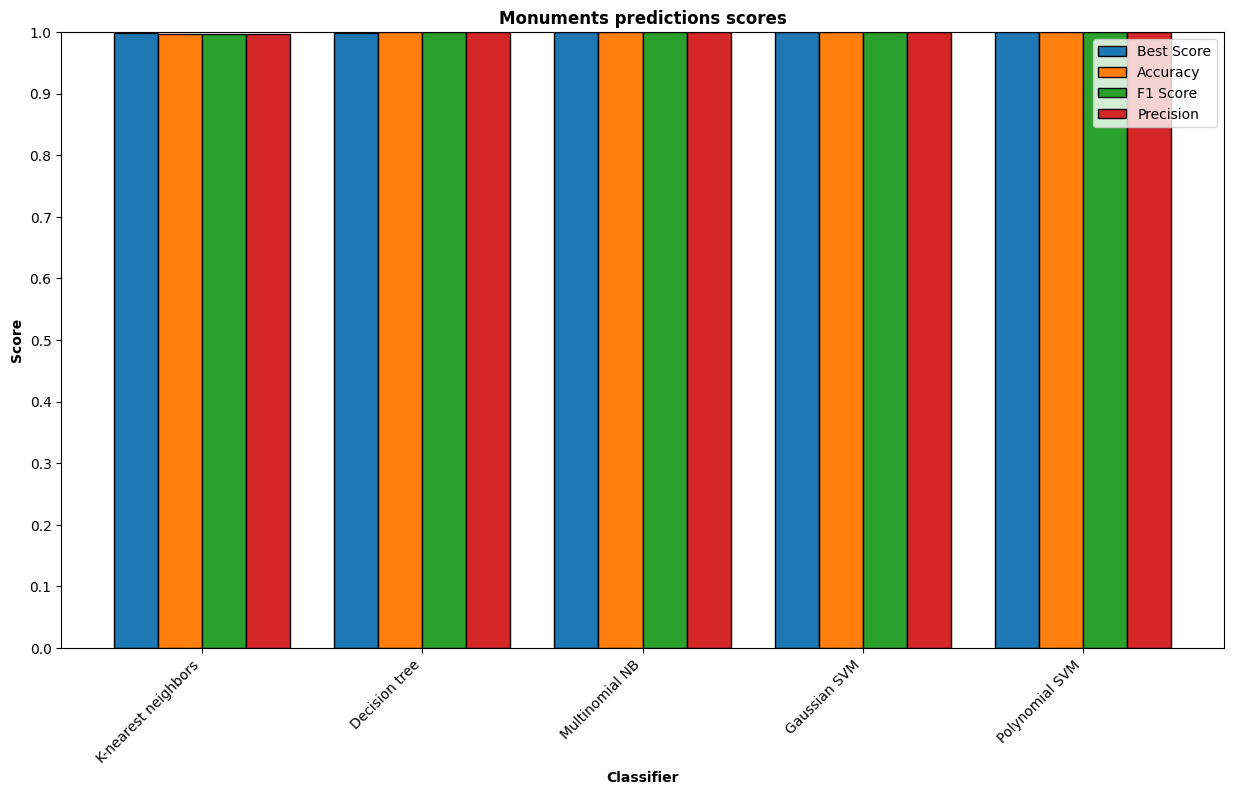

In [120]:
show_results_plot(results, "Monuments predictions scores")

In [121]:
# get the row corresponding to the Gaussian SVM classifier
svm_row = df.loc[df['Classifier'] == 'Gaussian SVM']

# get the prediction values for the Gaussian SVM classifier
svm_predictions = svm_row['Prediction'].values[0]

show_monuments_by_label(svm_predictions, X_test)

NameError: name 'vectorizer' is not defined